In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import words
from nltk.stem import PorterStemmer
from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#nltk.download('words')
#nltk.download('stopwords')
#nltk.download('punkt')

data_dir="datasets/"
dataset_name_dir="nfcorpus/"

In [2]:
corpus=pd.read_json(data_dir+dataset_name_dir+"corpus.jsonl", lines=True)
queries=pd.read_json(data_dir+dataset_name_dir+"queries.jsonl", lines=True)

In [3]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3633 entries, 0 to 3632
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   _id       3633 non-null   object
 1   title     3633 non-null   object
 2   text      3633 non-null   object
 3   metadata  3633 non-null   object
dtypes: object(4)
memory usage: 113.7+ KB


In [4]:
queries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3237 entries, 0 to 3236
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   _id       3237 non-null   object
 1   text      3237 non-null   object
 2   metadata  3237 non-null   object
dtypes: object(3)
memory usage: 76.0+ KB


### Sparse representation

In [5]:
class StemmedTfidfVectorizer(TfidfVectorizer):
    stemmer = PorterStemmer()
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: (StemmedTfidfVectorizer.stemmer.stem(w) for w in analyzer(doc))
    
class StemmedTfidfCountVectorizer(CountVectorizer):
    stemmer = PorterStemmer()
    def build_analyzer(self):
        analyzer = super(CountVectorizer, self).build_analyzer()
        return lambda doc: (StemmedTfidfCountVectorizer.stemmer.stem(w) for w in analyzer(doc))
    
    
def compute_sparse_repr(vocab: np.array, corpus: pd.DataFrame, queries: pd.DataFrame):
    doc_tfidf=StemmedTfidfVectorizer(lowercase=True, vocabulary=vocab, stop_words=None, token_pattern=r'\w+')
    q_counter=StemmedTfidfCountVectorizer(lowercase=True, vocabulary=vocab, stop_words=None, token_pattern=r'\w+')

    sparse_doc=doc_tfidf.fit_transform(corpus["text"])
    sparse_q=q_counter.fit_transform(queries["text"])

    return sparse_doc, sparse_q

In [19]:
stemmer=PorterStemmer()
vocab=np.unique([stemmer.stem(w) for w in np.char.lower(words.words())])
sparse_doc, sparse_q=compute_sparse_repr(vocab, corpus, queries)

#Here it's basically computed sparse_score=<q_sparse, d_sparse>
sparse_score_df=pd.DataFrame(np.dot(sparse_q, sparse_doc.transpose()).toarray(), index=queries["_id"], columns=corpus["_id"])

In [24]:
sparse_score_df.to_parquet("sparse_score_df_nfcorpus.parquet")

### Dense representation

In [ ]:
def compute_dense_repr(corpus: pd.DataFrame, queries: pd.DataFrame):
    transformers = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    dense_c=transformers.encode(corpus["text"], convert_to_numpy = True)
    dense_q=transformers.encode(queries["text"], convert_to_numpy = True)
    
    return dense_c, dense_q

In [ ]:
dense_c, dense_q=compute_dense_repr(corpus, queries)

#Here it's basically computed dense_score=<q_dense, d_dense>
dense_score_df=pd.DataFrame(np.dot(dense_q, dense_c.transpose()), index=queries["_id"], columns=corpus["_id"])

In [ ]:
sparse_score_df.to_parquet("sparse_score_df_nfcorpus.parquet")
dense_score_df.to_parquet("dense_score_dfnfcorpus.parquet")

## Top k retrieval

In [25]:
sparse_score_df=pd.read_parquet("sparse_score_df_nfcorpus.parquet")
dense_score_df=pd.read_parquet("dense_score_dfnfcorpus.parquet")

In [26]:
def compute_exact_retrieval(sparse_score_df: pd.DataFrame, dense_score_df: pd.DataFrame, k: int):
    total_score_df=sparse_score_df+dense_score_df

    idx_exact_top_k=np.argsort(total_score_df)[:, :-k-1:-1]
    top_k_exact_docs=np.array(total_score_df.columns[idx_exact_top_k.reshape(-1)]).reshape(-1, k)

    return total_score_df, top_k_exact_docs

In [27]:
k=5
total_score_df, top_k_exact_docs=compute_exact_retrieval(sparse_score_df, dense_score_df, k)

## Top k' retrieval (approximate case)

In [28]:
def compute_approx_retrieval(sparse_score_df: pd.DataFrame, dense_score_df: pd.DataFrame, total_score_df: pd.DataFrame, k_prime: int):
    idx_sparse_scores=np.argsort(sparse_score_df)[:, :-k_prime-1:-1]
    idx_dense_scores=np.argsort(dense_score_df)[:, :-k_prime-1:-1]

    concat_idx=np.concatenate((idx_sparse_scores, idx_dense_scores), axis=1)
    union_idx=[np.unique(x) for x in concat_idx]
    idx_approx_top_k=np.asarray([union_idx[i][np.argsort(total_score_df.iloc[i, union_idx[i]])[:-k-1:-1].values]
                    for i in range(len(union_idx))])
    top_k_approx_docs=np.array(total_score_df.columns[idx_approx_top_k.reshape(-1)]).reshape(-1, k)

    return top_k_approx_docs

## Evaluations

In [29]:
mean_recalls=[]
max_k_prime=k
for k_prime in range(k, k+1):
    top_k_approx_docs=compute_approx_retrieval(sparse_score_df, dense_score_df, total_score_df, k_prime)
    
    recall=[len(np.intersect1d(top_k_exact_docs[i], top_k_approx_docs[i], assume_unique=True))/k for i in range(len(top_k_exact_docs))]
    mean=np.mean(recall)
    mean_recalls.append(mean)

    max_k_prime=k_prime
    if mean==1:
        break

In [30]:
mean_recalls

[0.8889094840902069]

In [31]:
len(mean_recalls)

1

C:\Users\gioan\AppData\Local\Temp\ipykernel_9260\1547114748.py:4: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(k, max_k_prime)


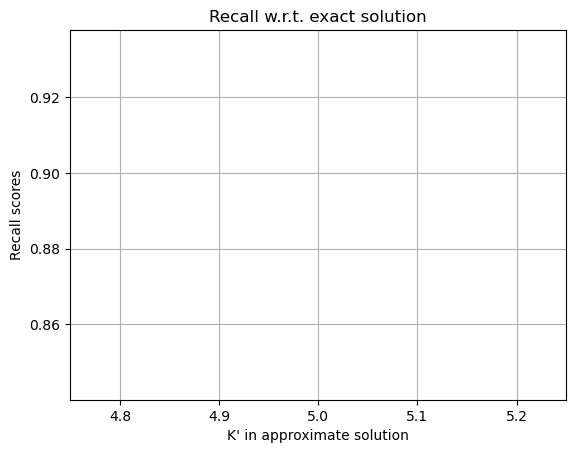

In [32]:
plt.title('Recall w.r.t. exact solution')
plt.ylabel('Recall scores')
plt.xlabel('K\' in approximate solution')
plt.xlim(k, max_k_prime)

plt.grid()
plt.plot(range(k, max_k_prime+1), mean_recalls, linewidth=2)
plt.show()

In [33]:
#TODO: FARE STEMMING